# Linear motion detection

Welcome! This Jupyter notebook shows a prettier view of the process of the experiment, as well as the results. When you're done looking at the fun stuff in this notebook, head on over and check out my actual [dissertation final report](report.pdf) and the other notebook where [the nitty gritty](main.ipynb) sits.

# Overview

When coming up with this project, the idea was this - Machine learning algorithms are taking the world of sensors data processing by storm. Recognition of types of motions is right in the ballpark of such algorithms, but they face a problem. The way they actually do classify is a total black box -- nobody can really tell *why* they decide the things they do. Approaches like that also struggle to generalise to varying subjects' motion.

But what if there was an approach more based in hard statistics - derived from concepts of physics and signal processing, using generalised likelihood estimates and a hypothesis testing approach? That's what this project explores, and spoiler: it works at about **78% accuracy** even for a proof-of-concept dissertation work!

## The data

First of all, I needed some inertial measurement data. I decided, in the end, to strap my phone to my wrist and record the accelerometer (my phone hasn't got a gyroscope) while I did some weights. Here's what I did...

- 10 curls with 7kg dumbbells
- 8 squats, with the same.

These exercises were perfect for detecting linear motion. Curls have zero linear motion component, and dumbbell squats have nothing but linear motion, when tracking the wrist.

## The method

First, I had to load the measurement data from its CSV files, and trim the data to when I knew the exercise was actually happening.

##### Imports

In [1]:
# Import necessary libraries and set parameters
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from datetime import datetime
from sklearn.metrics import accuracy_score
from IPython.display import display
from numpy.lib.stride_tricks import sliding_window_view

plt.rc("axes", axisbelow=True)

### Loading the data

In [3]:
# Read in data from CSV
curls_df = pd.read_csv("./data/sam/Curls_3x10_7kg-2024-01-25_16-55-30/TotalAcceleration.csv")
squat_df = pd.read_csv("./data/sam/Squats_3x8_7kg-2024-01-25_17-00-38/TotalAcceleration.csv")
curls_df

,time,seconds_elapsed,y,z,x,hypothesis
0,1.706202e+18,0.252757,-7.177817,6.464345,0.991199,NaN
1,1.706202e+18,0.274439,-7.551312,6.133945,1.216254,NaN
2,1.706202e+18,0.290274,-7.771579,5.315128,1.273715,NaN
3,1.706202e+18,0.306591,-8.087613,5.238513,0.900220,NaN
4,1.706202e+18,0.316342,-8.240842,5.722142,1.297657,NaN
...,...,...,...,...,...,...
3308,1.706202e+18,36.236247,1.015141,7.556100,7.144298,NaN
3309,1.706202e+18,36.246292,0.588974,7.513005,7.407660,NaN
3310,1.706202e+18,36.256083,0.378284,7.235278,6.971915,NaN
3311,1.706202e+18,36.266168,0.756568,7.163452,6.296751,NaN


## Trimming data to relevant periods

Data is trimmed so that it starts at the beginning of the first rep and ends at the end of the last rep.

In [4]:
def plot_accelerometer(df):
    """Plot accelerometer data as a line graph given a DataFrame with
    columns labelled `x`, `y` and `z`."""
    fig = plt.figure(figsize=(20, 3))  
    plt.subplot(1, 3, 1)
    plt.ylabel("Accelerometer $m/s^2$")
    plt.xlabel("Seconds elapsed (s)")
    plt.plot(df["seconds_elapsed"], df["x"], label="x")
    plt.plot(df["seconds_elapsed"], df["y"], label="y")
    ax = plt.plot(df["seconds_elapsed"], df["z"], label="z")

def plot_accelerometer_hyp(df):
    """Plot accelerometer data as a line graph alongside a hypothesis set
    given a DataFrame with columns labelled `x`, `y`, `z` and `hypothesis`."""
    fig = plt.figure(figsize=(20, 5))  
    plt.subplot(1, 3, 1)
    plt.ylabel("Accelerometer $m/s^2$")
    plt.xlabel("Seconds elapsed (s)")
    plt.plot(df["seconds_elapsed"], df["x"], label="x")
    plt.plot(df["seconds_elapsed"], df["y"], label="y")
    ax = plt.plot(df["seconds_elapsed"], df["z"], label="z")

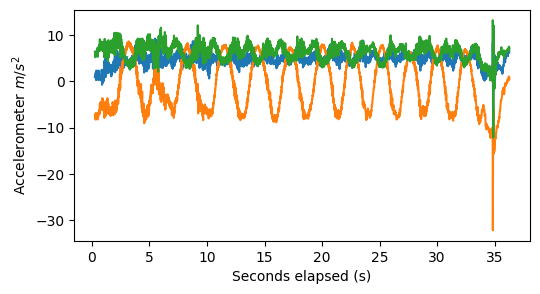

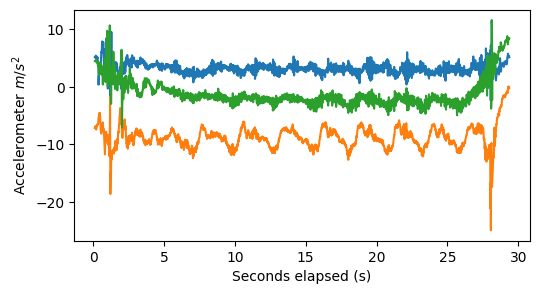

In [5]:
# Plot raw accelerometer data
plot_accelerometer(curls_df)
plot_accelerometer(squat_df)

In [6]:
# Trim curls to remove the picking up of weights at the beginning of
# the set and the putting down at the end of the set
curls_df_start = curls_df[curls_df["seconds_elapsed"] == 7.0367890625].index[0]
curls_df_end = curls_df[curls_df["seconds_elapsed"] == 33.48751904296875].index[0]
curls_df_trim = curls_df.iloc[curls_df_start:curls_df_end, :]

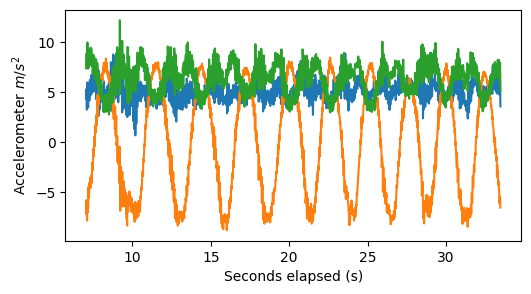

In [7]:
# Plot the trimmed curls data
plot_accelerometer(curls_df_trim)

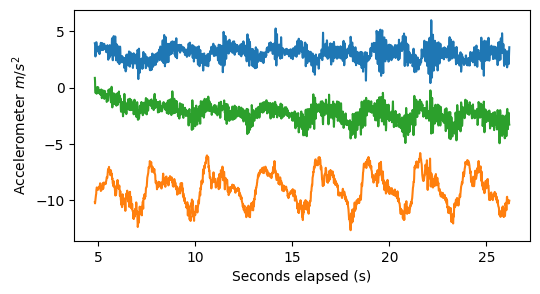

In [8]:
# Trim squats to remove the picking up of weights at the beginning of
# the set and the putting down at the end of the set
squat_df_start = squat_df[squat_df["seconds_elapsed"] == 4.837999267578125].index[0] #4.83
squat_df_end = squat_df[squat_df["seconds_elapsed"] == 26.19851220703125].index[0] #26.19
squat_df_trim = squat_df.iloc[squat_df_start:squat_df_end, :]
# Plot the trimmed squats data
plot_accelerometer(squat_df_trim)

## Labeling the data

After this the data needed some ground truth for tuning the parameters. Periods in the data representing certain motions were manually marked with the appropriate hypothesis, where $\mathcal{H}_0$ represented there being no linear movement (or no movement at all) and $\mathcal{H}_1$ representing linear movement.

|Exercise|Part|Hypothesis|
|-|-|-|
|Curls|Raising movement|$\mathcal{H}_0$|
|Curls|Lowering movement|$\mathcal{H}_0$|
|Curls|Motionless period between reps|$\mathcal{H}_0$|
|Squats|Raising movement|$\mathcal{H}_1$|
|Squats|Lowering movement|$\mathcal{H}_1$|
|Squats|Motionless period between reps|$\mathcal{H}_0$|

### Setting true hypotheses on trimmed data

#### Curls

In [9]:
# Set curls hypotheses to H_0
curls_df_trim.loc[:, 'hypothesis'] = 0
# ax = plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["hypothesis"])

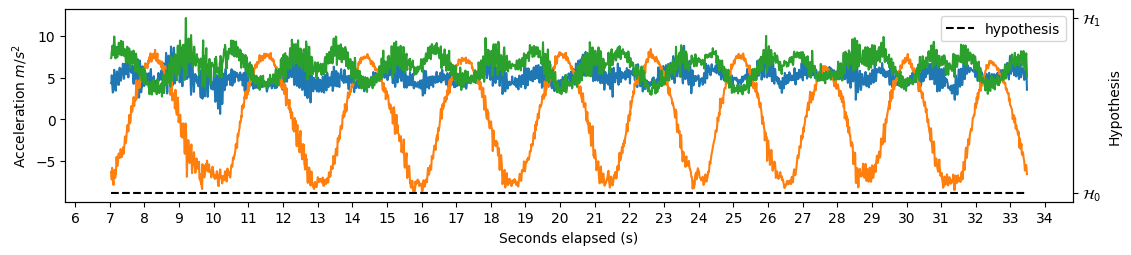

In [10]:
# Plot accelerometer data and hypothesis on the same graph
plt.figure(figsize=(13, 2.5))
plt.xlabel("Seconds elapsed (s)")
plt.ylabel("Acceleration $m/s^2$")
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["x"], label="x")
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["y"], label="y")
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["z"], label="z")

plt.twinx()
plt.ylim(-0.05, 1.05)
plt.ylabel("Hypothesis")
plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["hypothesis"], label="hypothesis", linestyle="--", color="black")
plt.legend()
plt.grid(visible=True, axis="x", linestyle="--")
a = plt.xticks(np.arange(6, 35, 1))

#### Squats

In [12]:
# Motionless end   - idx 0
# Bottom of rep 1  - 7.03787s - H1 - 7.037873779296875
# Top of rep 1     - 7.75819s - H1 - 7.75818505859375
# Motionless end 1 - 9.32852s - H0 - 9.328517822265624
# Bottom of rep 2  - 9.76746s - H1 - 9.7674619140625
# Top of rep 2     - 10.5975s - H1 - 10.597513916015625
# Motionless end 2 - 11.9576s - H0 - 11.957637939453125
# Bottom of rep 3  - 12.7275s - H1 - 12.727472900390625
# Top of rep 3     - 13.618s  - H1 - 13.618012939453125
# Motionless end 3 - 14.9384s - H0 - 14.93835205078125
# Bottom of rep 4  - 15.8475s - H1 - 15.8475068359375
# Top of rep 4     - 16.4283s - H1 - 16.428326904296874
# Motionless end 4 - 17.368s  - H0 - 17.36797705078125
# Bottom of rep 5  - 18.2379s - H1 - 18.237943115234376
# Top of rep 5     - 18.938s  - H1 - 18.938011962890624
# Motionless end 5 - 20.1391s - H0 - 20.139137939453125
# Bottom of rep 6  - 21.0387s - H1 - 21.03868115234375
# Top of rep 6     - 21.6189s - H1 - 21.618908935546877
# Motionless end 6 - 22.5000s - H0 - 22.507530029296873
# Bottom of rep 6  - 23.2380s - H1 - 23.2380419921875
# Top of rep 7     - 24.0281s - H1 - 24.028087158203125
# Motionless end 7 - 25.0486s - H0 - 25.048609130859376
# Bottom of rep 8  - 25.7177s - H1 - 25.71772119140625
# Top of rep 8     - 26.7175s - H1 - 26.717465087890623
# Motionless end 8 - 27.5377s - H0 - 27.537717041015625

conds = [
    (squat_df_trim["seconds_elapsed"] >= 0.0)                & (squat_df_trim["seconds_elapsed"] < 7.037873779296875),
    (squat_df_trim["seconds_elapsed"] >= 7.037873779296875) & (squat_df_trim["seconds_elapsed"] < 7.75818505859375),
    (squat_df_trim["seconds_elapsed"] >= 7.75818505859375) & (squat_df_trim["seconds_elapsed"] < 9.328517822265624),
    (squat_df_trim["seconds_elapsed"] >= 9.328517822265624) & (squat_df_trim["seconds_elapsed"] < 9.7674619140625),
    (squat_df_trim["seconds_elapsed"] >= 9.7674619140625) & (squat_df_trim["seconds_elapsed"] < 10.597513916015625),
    (squat_df_trim["seconds_elapsed"] >= 10.597513916015625) & (squat_df_trim["seconds_elapsed"] < 11.957637939453125),
    (squat_df_trim["seconds_elapsed"] >= 11.957637939453125) & (squat_df_trim["seconds_elapsed"] < 12.727472900390625),
    (squat_df_trim["seconds_elapsed"] >= 12.727472900390625) & (squat_df_trim["seconds_elapsed"] < 13.618012939453125),
    (squat_df_trim["seconds_elapsed"] >= 13.618012939453125) & (squat_df_trim["seconds_elapsed"] < 14.93835205078125),
    (squat_df_trim["seconds_elapsed"] >= 14.93835205078125) & (squat_df_trim["seconds_elapsed"] < 15.8475068359375),
    (squat_df_trim["seconds_elapsed"] >= 15.8475068359375) & (squat_df_trim["seconds_elapsed"] < 16.428326904296874),
    (squat_df_trim["seconds_elapsed"] >= 16.428326904296874) & (squat_df_trim["seconds_elapsed"] < 17.36797705078125),
    (squat_df_trim["seconds_elapsed"] >= 17.36797705078125) & (squat_df_trim["seconds_elapsed"] < 18.237943115234376),
    (squat_df_trim["seconds_elapsed"] >= 18.237943115234376) & (squat_df_trim["seconds_elapsed"] < 18.938011962890624),
    (squat_df_trim["seconds_elapsed"] >= 18.938011962890624) & (squat_df_trim["seconds_elapsed"] < 20.139137939453125),
    (squat_df_trim["seconds_elapsed"] >= 20.139137939453125) & (squat_df_trim["seconds_elapsed"] < 21.03868115234375),
    (squat_df_trim["seconds_elapsed"] >= 21.03868115234375) & (squat_df_trim["seconds_elapsed"] < 21.618908935546877),
    (squat_df_trim["seconds_elapsed"] >= 21.618908935546877) & (squat_df_trim["seconds_elapsed"] < 22.507530029296873),
    (squat_df_trim["seconds_elapsed"] >= 22.507530029296873) & (squat_df_trim["seconds_elapsed"] < 23.2380419921875),
    (squat_df_trim["seconds_elapsed"] >= 23.2380419921875)& (squat_df_trim["seconds_elapsed"] < 24.028087158203125),
    (squat_df_trim["seconds_elapsed"] >= 24.028087158203125) & (squat_df_trim["seconds_elapsed"] < 25.048609130859376),
    (squat_df_trim["seconds_elapsed"] >= 25.048609130859376) & (squat_df_trim["seconds_elapsed"] < 25.71772119140625),
    (squat_df_trim["seconds_elapsed"] >= 25.71772119140625) & (squat_df_trim["seconds_elapsed"] < 26.717465087890623),
    (squat_df_trim["seconds_elapsed"] >= 26.717465087890623) & (squat_df_trim["seconds_elapsed"] < 27.537717041015625),
]

values = [1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0]
true_hyps = np.select(conds, values)
squat_df_trim.loc[:, 'hypothesis'] = true_hyps

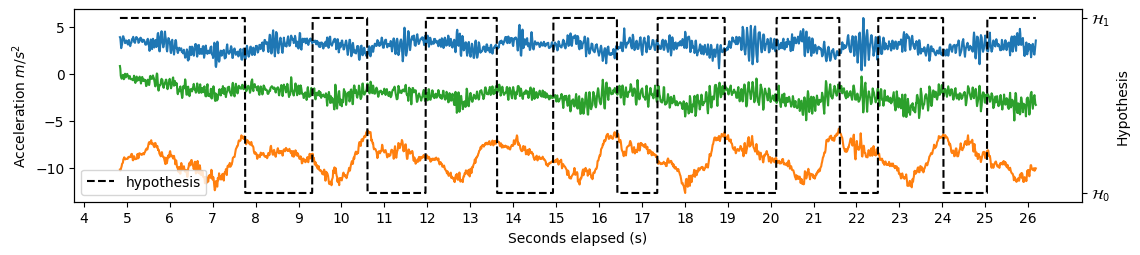

In [13]:
# Plot accelerometer data and hypothesis on the same graph
plt.figure(figsize=(13, 2.5))
plt.xlabel("Seconds elapsed (s)")
plt.ylabel("Acceleration $m/s^2$")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["x"], label="x")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["y"], label="y")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["z"], label="z")

plt.twinx()
plt.ylim(-0.05, 1.05)
plt.ylabel("Hypothesis")
plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
plt.plot(squat_df_trim["seconds_elapsed"], np.select(conds, values), label="hypothesis", linestyle="--", color="black")
plt.legend()
plt.grid(visible=True, axis="x", linestyle="--")
a= plt.xticks(np.arange(4, 27, 1))

## Computing the test statistics

After this came the tough process of translating the mathematical concepts underpinning this approach into real, executable code.
If you'd like to check out the maths, read the [report](report.pdf).

In [14]:
def SSM(vector):
    """Return the skew symmetric matrix [a]_x for a vector a such that [a]_x b = a x b"""
    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[1]],
            [vector[1], vector[0], 0],
        ]
    )


def calc_min_ev(alpha_beta_gamma: tuple[3], y):
    """Calculate the minimum eigenvalue
    This function will be minimized on the direction of gravity

    y is a sliding window about a certain measurement"""
    u_g = np.array(alpha_beta_gamma)
    g = 9.81

    M = np.zeros((3, 3))
    for y_k in y:  # [x, y, z]
        measurement = y_k + (g * u_g)
        M += SSM(measurement).T * SSM(measurement)

    if np.isnan(np.ravel(M)).any():
        return 9999999999999999999

    eigvs, _ = np.linalg.eig(M)
    return min(eigvs)

In [15]:
def optimise_u_g(y, guess=(0.1, 0.1, 0.1)):
    """Use scipy to optimise the alpha and beta for the min min eig"""
    res = scipy.optimize.minimize(
        fun=calc_min_ev,
        x0=guess,
        args=(y,),
        constraints=[{"type": "eq", "fun": lambda x: np.sum(np.array(x) ** 2) - 1}],
        method="trust-constr",
    )
    return res

In [16]:
def decide_on_hypothesis(test_statistics, gamma):
    """Decide on hypothesis at each point."""
    return test_statistics > gamma

def calc_true_positives(decisions, true_hyps):
    """Calculate the proportion of H1 (translational motion) that were correctly identified."""
    return np.mean((decisions == 1) & (true_hyps == 1))

def calc_false_positives(decisions, true_hyps):
    """Calculate the proportion of H0 (no translational motion) that were incorrectly identified as H1."""
    return np.mean((decisions == 1) & (true_hyps == 0))

def calc_true_negatives(decisions, true_hyps):
    """Calculate the proportion of H0 (no translational motion) that were correctly identified."""
    return np.mean((decisions == 0) & (true_hyps == 0))

def calc_false_negatives(decisions, true_hyps):
    """Calculate the proportion of H1 (translational motion) that were incorrectly identified as H0."""
    return np.mean((decisions == 0) & (true_hyps == 1))

def plot_hypotheses(x, hypotheses, left_lim, right_lim, s=None, color="tab:blue"):
    plt.ylim(-0.1, 1.1)
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.xticks(np.arange(left_lim, right_lim, 1))
    plt.grid(axis="x", linestyle="--")
    plt.xlim(left_lim, right_lim)
    ax = plt.scatter(x, hypotheses, s=s, color=color)
    return ax

In [17]:
def measurement_window(measurements, n, stride=1):
    """
    Create sliding windows of size 'n' from the measurements data.

    Parameters:
    measurements (DataFrame): The input measurements data.
    n (int): The size of the sliding window.
    stride (int, optional): The stride value for the sliding window. Defaults to 1.

    Returns:
    ndarray: The sliding windows of size 'n' from the measurements data.
    """
    x_sw = sliding_window_view(measurements["x"].to_numpy(), n)
    y_sw = sliding_window_view(measurements["y"].to_numpy(), n)
    z_sw = sliding_window_view(measurements["z"].to_numpy(), n)

    # Combine x, y and z into 3D vectors for each measurement in the sliding window
    sw = np.stack((x_sw, y_sw, z_sw), axis=-1)
    return sw[::stride]

# sw_100[k] is the kth window of 100 measurements
# sw_100[k][j] is the jth measurement in the kth window
# sw_100[k][j][i] is the ith coordinate of the jth measurement in the kth window

In [18]:
def min_min_evs(windows):
    """Calculate the minimum of the minimum eigenvalues for each window"""
    Ts = []  # min min eigs

    for window in windows:
        res = optimise_u_g(window)
        min_min_ev = res.fun
        Ts.append(min_min_ev)

    return Ts

In [19]:
squat_window_stride = 10
squat_window_size = 100
curl_window_stride = 10
curl_window_size = 100

In [20]:
# Compute the test statistics for squats
squat_Ts = min_min_evs(measurement_window(squat_df_trim, squat_window_size, stride=squat_window_stride))
# squat_Ts = pd.read_csv("data/sam/squat_Ts_stride_10_size_100.csv").to_numpy().flatten()

In [21]:
# Compute the test statistics for curls
curl_Ts = min_min_evs(measurement_window(curls_df_trim, curl_window_size, stride=curl_window_stride))
# curl_Ts = pd.read_csv("./data/sam/curl_Ts_stride_10_size_100.csv").to_numpy().flatten()

In [22]:
# Create a copy of both dataframes with stride and trimmed to the correct length
squat_df_trim_s10 = squat_df_trim[::squat_window_stride]
curls_df_trim_s10 = curls_df_trim[::curl_window_stride]
# Trim to length of Ts
squat_df_trim_s10 = squat_df_trim_s10[:len(squat_Ts)]
curls_df_trim_s10 = curls_df_trim_s10[:len(curl_Ts)]

print("Squats")
print(squat_df_trim_s10.shape)
print(pd.Series(squat_Ts).shape)

print()

print("Curls")
print(curls_df_trim_s10.shape)
print(pd.Series(curl_Ts).shape)

Squats
(184, 6)
(184,)

Curls
(231, 6)
(231,)


## Plotting the test statistics

Now I had the test statistics for each sliding window of measurement data, and it was time to see what it looked like. You can clearly see the reps visible in the values.

In [23]:
def eigplot_double(Ts_1, Ts_2, title1, title2, window_size1, window_size2, window_stride1, window_stride2, suptitle):
    """Plot two sets of test statistics on side by side graphs."""
    plt.figure(figsize=(15, 4))
    plt.suptitle(suptitle)

    plt.subplot(1, 2, 1)
    plt.title(f"{title1} (window size={window_size1}, stride={window_stride1})")
    plt.ylabel("Min min eigenvalue")
    ax = pd.Series(Ts_1).plot(color="tab:blue")

    plt.subplot(1, 2, 2)
    plt.title(f"{title2} (window size={window_size2}, stride={window_stride2})")
    ax = pd.Series(Ts_2).plot(color="tab:orange")

In [24]:
def eigplot_two_together(Ts_1, Ts_2):
    """Plot two sets of test statistics on the same graph."""
    plt.ylabel("Min min eigenvalue")
    plt.xticks([])
    ax = pd.Series(Ts_1).plot(color="tab:blue")
    ax = pd.Series(Ts_2).plot(color="tab:orange")

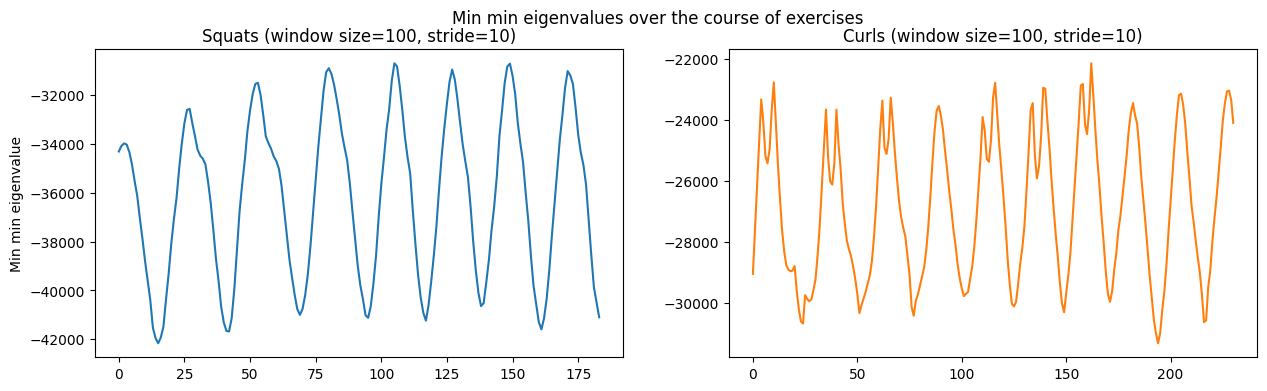

In [25]:
# Exploratory eigenvalue plot
eigplot_double(
    squat_Ts,
    curl_Ts,
    "Squats",
    "Curls",
    squat_window_size,
    curl_window_size,
    squat_window_stride,
    curl_window_stride,
    "Min min eigenvalues over the course of exercises",
)

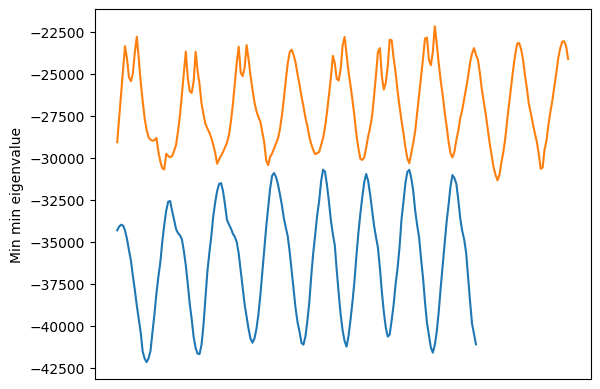

In [26]:
# Double plot
eigplot_two_together(squat_Ts, curl_Ts)

Clear separation visible

## Grid searching gammas for the best threshold

Now it was time to grid search for the decision threshold value $\gamma$ which would decide the most accurate set of classifications! This was done with a grid search because of the relatively small amount of data it had to chew through - other optimisation methods could have been used here too.

In [27]:
def grid_search_gammas(Ts, true_hyps, left, right, step):
    """Given the test statistics `Ts` and true hypotheses `true_hyps`,
    grid search across all values of gamma between `left` and `right`
    at an interval of `step`, calculating true and false positive and negative
    rates, as well as accuracies and hypothesis sets."""
    gammas = np.arange(left, right, step)
    accs_arr = []
    true_pos_arr = []
    false_pos_arr = []
    true_neg_arr = []
    false_neg_arr = []
    hyp_sets = []

    for gamma in gammas:
        decisions = decide_on_hypothesis(Ts, gamma)

        accs_arr.append(accuracy_score(true_hyps, decisions))
        tp = calc_true_positives(decisions, true_hyps)
        fp = calc_false_positives(decisions, true_hyps)
        tn = calc_true_negatives(decisions, true_hyps)
        fn = calc_false_negatives(decisions, true_hyps)
        
        if tp == 0:
            tpr = 0 # divide by zero doesn't matter because numerator is 0 anyway
        else:
            tpr = tp/(tp+fn)
        if fp == 0:
            fpr = 0 # divide by zero doesn't matter because numerator is 0 anyway
        else:
            fpr = fp/(fp+tn)

        tnr = 1 - fpr
        fnr = 1 - tpr
        
        true_pos_arr.append(tpr)
        false_pos_arr.append(fpr)
        true_neg_arr.append(tnr)
        false_neg_arr.append(fnr)

        hyp_sets.append(decisions)

    return gammas, accs_arr, true_pos_arr, false_pos_arr, true_neg_arr, false_neg_arr, hyp_sets

#### Squats

In [28]:
# Grid search thresholds
# squat_gamma_lower = -50_000
# squat_gamma_upper = -20_000
squat_gamma_lower = np.min(squat_Ts)
squat_gamma_upper = np.max(squat_Ts)
squat_gamma_step = 1

(
    squat_gammas,
    squat_accs_arr,
    squat_true_pos_arr,
    squat_false_pos_arr,
    squat_true_neg_arr,
    squat_false_neg_arr,
    squat_hyp_sets,
) = grid_search_gammas(
    squat_Ts,
    squat_df_trim_s10["hypothesis"].values,
    squat_gamma_lower,
    squat_gamma_upper,
    squat_gamma_step,
)

#### Curls

In [29]:
# Grid search thresholds
# curl_gamma_lower = -35_000
# curl_gamma_upper = -20_000
curl_gamma_lower = np.min(curl_Ts)
curl_gamma_upper = np.max(curl_Ts)
curl_gamma_step = 1
(
    curl_gammas,
    curl_accs_arr,
    curl_true_pos_arr,
    curl_false_pos_arr,
    curl_true_neg_arr,
    curl_false_neg_arr,
    curl_hyp_sets,
) = grid_search_gammas(
    curl_Ts,
    curls_df_trim_s10["hypothesis"].values,
    curl_gamma_lower,
    curl_gamma_upper,
    curl_gamma_step,
)

## Plotting classification metrics

The process of grid searching over decision thresholds left me with lots of juicy metrics about all the different classifications - I plot the interesting ones here.

In [30]:
def plot_class_metrics(gammas, true_pos_arr, false_pos_arr, true_neg_arr, false_neg_arr):
    """Plot the classification metrics."""
    plt.subplot(2, 2, 1)
    plt.title("True positive rate (sensitivity)")
    plt.xlabel("$ \gamma $")
    plt.plot(gammas, true_pos_arr, color="tab:blue")
    plt.subplot(2, 2, 2)
    plt.title("False positive rate (1 - specificity)")
    plt.xlabel("$ \gamma $")
    plt.plot(gammas, false_pos_arr, color="tab:orange")
    plt.subplot(2, 2, 3)
    plt.title("True negative rate (specificity)")
    plt.xlabel("$ \gamma $")
    plt.plot(gammas, true_neg_arr, color="tab:green")
    plt.subplot(2, 2, 4)
    plt.title("False negative rate (1 - sensitivity)")
    plt.xlabel("$ \gamma $")
    plt.plot(gammas, false_neg_arr, color="tab:red")
    plt.tight_layout()

#### Squats

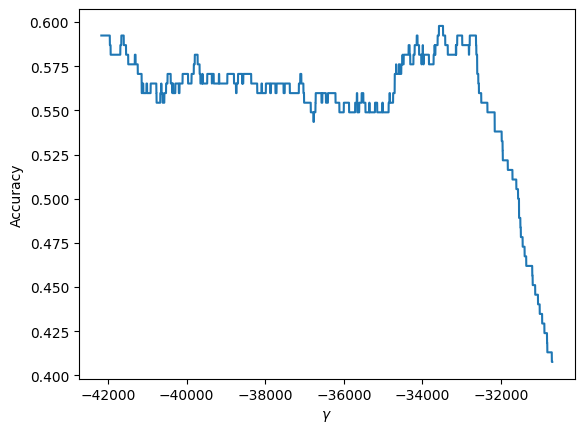

In [31]:
# Plot accuracy against gamma for squats
plt.xlabel("$\gamma$")
plt.ylabel("Accuracy")
ax = plt.plot(squat_gammas, squat_accs_arr)

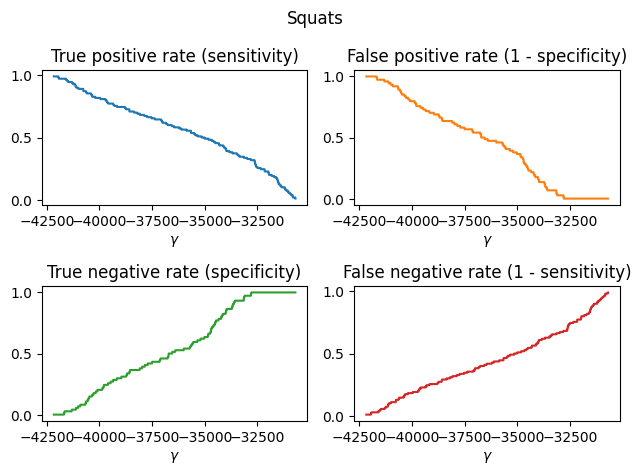

In [32]:
# Plot metrics for squats
t = plt.suptitle("Squats")
plot_class_metrics(
    squat_gammas,
    squat_true_pos_arr,
    squat_false_pos_arr,
    squat_true_neg_arr,
    squat_false_neg_arr,
)

#### Curls

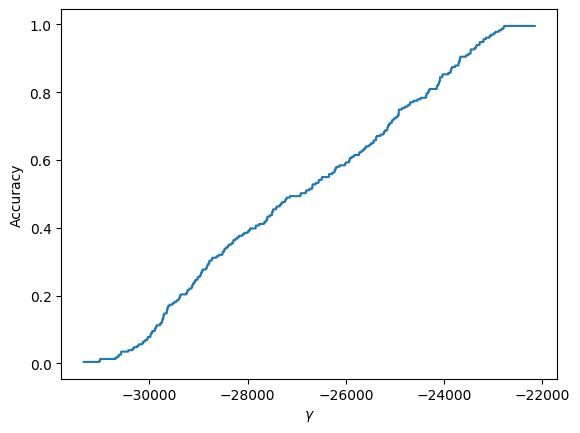

In [34]:
# Plot accuracy against gamma for curls
plt.xlabel("$\gamma$")
plt.ylabel("Accuracy")
ax = plt.plot(curl_gammas, curl_accs_arr)

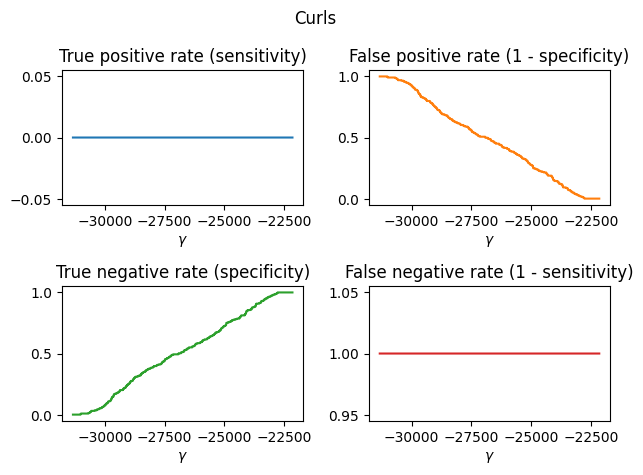

In [35]:
# Plot metrics for curls
t = plt.suptitle("Curls")
plot_class_metrics(
    curl_gammas,
    curl_true_pos_arr,
    curl_false_pos_arr,
    curl_true_neg_arr,
    curl_false_neg_arr,
)

## Plotting hypotheses

What was also interesting was the actual decision sets that yielded the highest or lowest values of metrics, versus the true hypothesis. You can see in the *highest accuracy* hypothesis plots that the algorithm makes a real effort at classifying the motions appropriately - this approach is promising!

In [39]:
# Set the dot size for hypothesis plots
dot_size = 30

In [40]:
def side_by_side_hyps(x, y1, y2, left, right, s=1):
    """Plot two sets of hypotheses side by side."""
    fig = plt.figure(figsize=(15, 3))
    fig.supylabel("Hypothesis")
    fig.supxlabel("Seconds elapsed (s)")

    plt.subplot(2, 1, 1)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 1))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax1 = plt.scatter(x, y1, s=s, color="tab:blue")

    plt.subplot(2, 1, 2)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 1))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax2 = plt.scatter(x, y2, s=s, color="tab:orange")
    return ax1, ax2

In [42]:
def hyps_octa_plot(x, y1, y2, y3, y4, y5, y6, y7, y8, left, right, titles, s=1):
    """Plot eight sets of hypotheses. in a 2x4 layout."""
    fig = plt.figure(figsize=(15, 4))
    fig.supylabel("Hypothesis")
    fig.supxlabel("Seconds elapsed (s)")

    plt.subplot(2, 4, 1)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax1 = plt.scatter(x, y1, s=s, color="tab:blue")
    plt.title(titles[0])

    plt.subplot(2, 4, 2)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax2 = plt.scatter(x, y2, s=s, color="tab:orange")
    plt.title(titles[1])

    plt.subplot(2, 4, 3)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y3, s=s, color="tab:green")
    plt.title(titles[2])

    plt.subplot(2, 4, 4)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y4, s=s, color="tab:red")
    plt.title(titles[3])

    plt.subplot(2, 4, 5)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y5, s=s, color="tab:purple")
    plt.title(titles[4])

    plt.subplot(2, 4, 6)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y6, s=s, color="tab:brown")
    plt.title(titles[5])

    plt.subplot(2, 4, 7)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y7, s=s, color="tab:pink")
    plt.title(titles[6])

    plt.subplot(2, 4, 8)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y8, s=s, color="tab:gray")
    plt.title(titles[7])

#### Squats

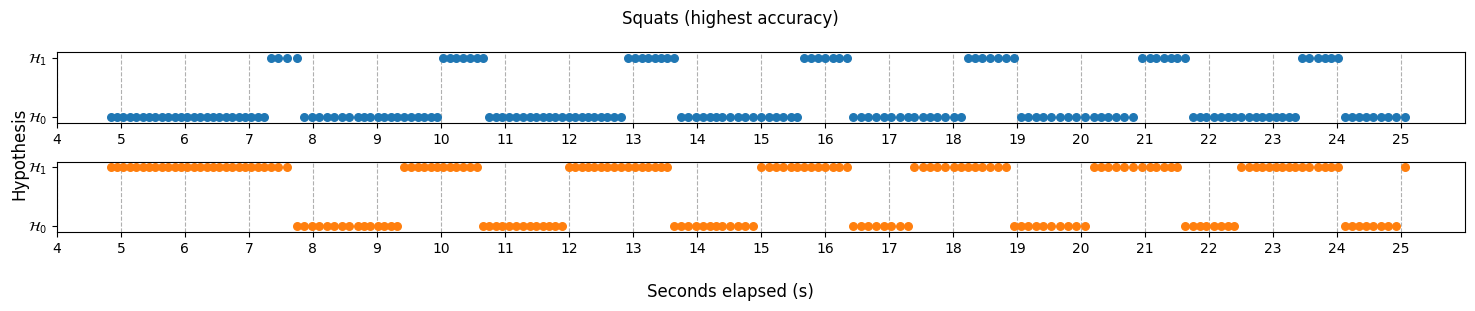

In [43]:
# Highest accuracy
side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_accs_arr)],
    squat_df_trim_s10["hypothesis"],
    4,
    26,
    s=dot_size
)
plt.suptitle("Squats (highest accuracy)")
plt.tight_layout()

##### Octa plot

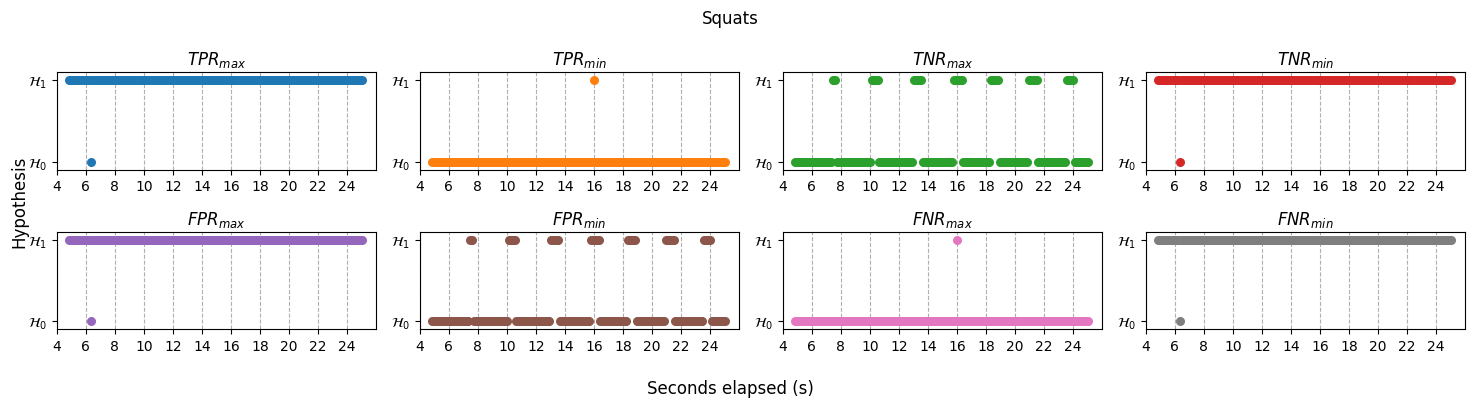

In [52]:
# Squats octa plot for max and min of all 8 metrics
hyps_octa_plot(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_true_pos_arr)],
    squat_hyp_sets[np.argmin(squat_true_pos_arr)],
    squat_hyp_sets[np.argmax(squat_true_neg_arr)],
    squat_hyp_sets[np.argmin(squat_true_neg_arr)],
    squat_hyp_sets[np.argmax(squat_false_pos_arr)],
    squat_hyp_sets[np.argmin(squat_false_pos_arr)],
    squat_hyp_sets[np.argmax(squat_false_neg_arr)],
    squat_hyp_sets[np.argmin(squat_false_neg_arr)],
    4,
    26,
    ["$TPR_{max}$", "$TPR_{min}$", "$TNR_{max}$", "$TNR_{min}$", "$FPR_{max}$", "$FPR_{min}$", "$FNR_{max}$", "$FNR_{min}$"],
    s=dot_size
)
plt.suptitle("Squats")
plt.tight_layout()

##### Key takeaways
- The classification with the **highest accuracy** presents a meaningful-looking classification.
    - The highest accuracy $\neq$ the highest true positive/lowest false positive rate.
- The classification with the **lowest false positive** rate is identical to the one with the **highest true negative** rate.
    - These make a pretty good attempt at classifying.
- The classification with the **highest true positive** rate is identical to the one with the **lowest false negative** rate.
    - These just guess $ \mathcal{H}_1 $ for every measurement window.
- The classification with the **highest precision** is identical to the lowest false positive and highest true negative.
    - The highest precision is 1.0 

#### Curls

##### Individual plots

In [53]:
curl_left_lim = 6
curl_right_lim = 33

0.9956709956709957


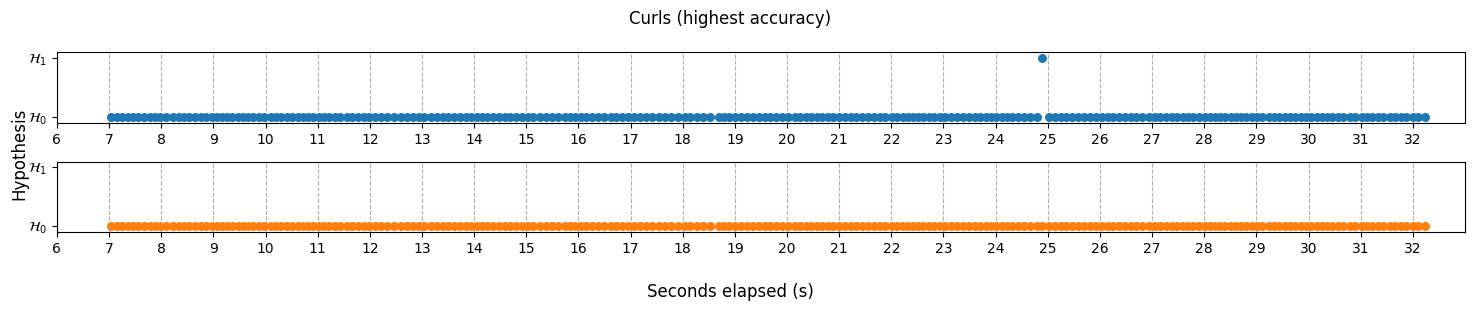

In [54]:
# Highest accuracy

side_by_side_hyps(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmax(curl_accs_arr)],
    curls_df_trim_s10["hypothesis"],
    curl_left_lim,
    curl_right_lim,
    s=dot_size
)
plt.suptitle("Curls (highest accuracy)")
plt.tight_layout()
print(max(curl_accs_arr))

##### Octa plot

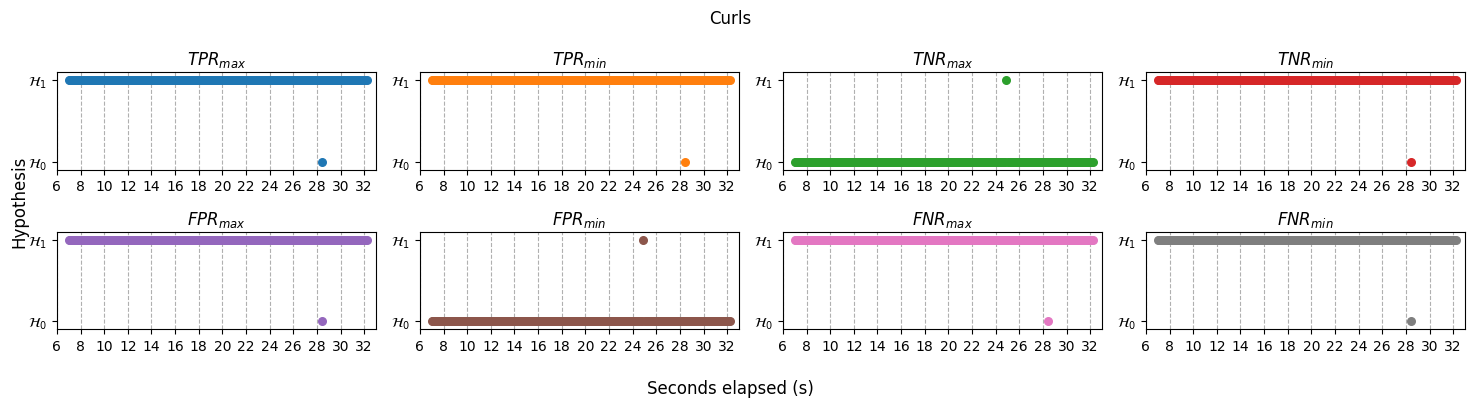

In [64]:
# Curls octa plot for max and min of all 8 metrics
hyps_octa_plot(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmax(curl_true_pos_arr)],
    curl_hyp_sets[np.argmin(curl_true_pos_arr)],
    curl_hyp_sets[np.argmax(curl_true_neg_arr)],
    curl_hyp_sets[np.argmin(curl_true_neg_arr)],
    curl_hyp_sets[np.argmax(curl_false_pos_arr)],
    curl_hyp_sets[np.argmin(curl_false_pos_arr)],
    curl_hyp_sets[np.argmax(curl_false_neg_arr)],
    curl_hyp_sets[np.argmin(curl_false_neg_arr)],
    curl_left_lim,
    curl_right_lim,
    ["$TPR_{max}$", "$TPR_{min}$", "$TNR_{max}$", "$TNR_{min}$", "$FPR_{max}$", "$FPR_{min}$", "$FNR_{max}$", "$FNR_{min}$"],
    s=dot_size
)
plt.suptitle("Curls")
plt.tight_layout()

##### Key takeaways
- There are never any true positives, or false negatives.
    - There can be no true positives because NONE of the motion is translative, therefore at all moments the hypothesis is $\mathcal{H}_0$.
    - You can never be wrong to classify a window as $\mathcal{H}_0$, therefore there can be no false negatives either.
- The highest precision is 1.0.
- All recalls are 1.0.
- These metrics don't really seem to apply.
- Not much insight to be gathered from an exercise that's just always $\mathcal{H}_0$

All this naturally led on to varying the size and stride (how many values between each window) for the sliding windows, to see how it might affect the accuracy of decision making. For the sake of brevity, I'll spare you the same process repeated three more times, graphs and all, and just calculate the data. Feel free to skip to the [comparison section](#inter-experiment-comparison).

# Again: 50/10
50 window size, 10 stride.

In [65]:
# Compute the test statistics for squats
squat_Ts_50_10 = min_min_evs(measurement_window(squat_df_trim, 50, stride=10))
# squat_Ts_50_10 = pd.read_csv("data/sam/squat_Ts_50_10.csv").to_numpy().flatten()

In [66]:
# Compute the test statistics for curls
curl_Ts_50_10 = min_min_evs(measurement_window(curls_df_trim, 50, stride=10))
# curl_Ts_50_10 = pd.read_csv("data/sam/curl_Ts_50_10.csv").to_numpy().flatten()

In [68]:
# Trim the Ts to the length of the hypotheses
squat_Ts_50_10 = squat_Ts_50_10[:len(squat_df_trim_s10)]
curl_Ts_50_10 = curl_Ts_50_10[:len(curls_df_trim_s10)]

In [71]:
# Grid search gamma for squats
squat_50_10_gamma_lower = np.min(squat_Ts_50_10)
squat_50_10_gamma_upper = np.max(squat_Ts_50_10)
squat_50_10_gamma_step = 1

(
    squat_50_10_gammas,
    squat_50_10_accs_arr,
    squat_50_10_true_pos_arr,
    squat_50_10_false_pos_arr,
    squat_50_10_true_neg_arr,
    squat_50_10_false_neg_arr,
    squat_50_10_hyp_sets,
) = grid_search_gammas(
    squat_Ts_50_10,
    squat_df_trim_s10["hypothesis"].values,
    squat_50_10_gamma_lower,
    squat_50_10_gamma_upper,
    squat_50_10_gamma_step,
)

In [72]:
# Grid search gamma for curls
curl_50_10_gamma_lower = np.min(curl_Ts_50_10)
curl_50_10_gamma_upper = np.max(curl_Ts_50_10)
curl_50_10_gamma_step = 1

(
    curl_50_10_gammas,
    curl_50_10_accs_arr,
    curl_50_10_true_pos_arr,
    curl_50_10_false_pos_arr,
    curl_50_10_true_neg_arr,
    curl_50_10_false_neg_arr,
    curl_50_10_hyp_sets,
) = grid_search_gammas(
    curl_Ts_50_10,
    curls_df_trim_s10["hypothesis"].values,
    curl_50_10_gamma_lower,
    curl_50_10_gamma_upper,
    curl_50_10_gamma_step,
)

# Again: 150/10

In [83]:
# Compute the test statistics for squats
squat_Ts_150_10 = min_min_evs(measurement_window(squat_df_trim, 150, stride=10))
# squat_Ts_150_10 = pd.read_csv("data/sam/squat_Ts_150_10.csv").to_numpy().flatten()

In [84]:
# Compute the test statistics for curls
curl_Ts_150_10 = min_min_evs(measurement_window(curls_df_trim, 150, stride=10))
# curl_Ts_150_10 = pd.read_csv("data/sam/curl_Ts_150_10.csv").to_numpy().flatten()

In [88]:
# Grid search gamma
squat_150_10_gamma_lower = np.min(squat_Ts_150_10)
squat_150_10_gamma_upper = np.max(squat_Ts_150_10)
squat_150_10_gamma_step = 1

(
    squat_150_10_gammas,
    squat_150_10_accs_arr,
    squat_150_10_true_pos_arr,
    squat_150_10_false_pos_arr,
    squat_150_10_true_neg_arr,
    squat_150_10_false_neg_arr,
    squat_150_10_hyp_sets,
) = grid_search_gammas(
    squat_Ts_150_10,
    squat_df_trim_s10["hypothesis"].values[:len(squat_Ts_150_10)],
    squat_150_10_gamma_lower,
    squat_150_10_gamma_upper,
    squat_150_10_gamma_step,
)

In [89]:
# Grid search gamma
curl_150_10_gamma_lower = np.min(curl_Ts_150_10)
curl_150_10_gamma_upper = np.max(curl_Ts_150_10)
curl_150_10_gamma_step = 1

(
    curl_150_10_gammas,
    curl_150_10_accs_arr,
    curl_150_10_true_pos_arr,
    curl_150_10_false_pos_arr,
    curl_150_10_true_neg_arr,
    curl_150_10_false_neg_arr,
    curl_150_10_hyp_sets,
) = grid_search_gammas(
    curl_Ts_150_10,
    curls_df_trim_s10["hypothesis"].values[:len(curl_Ts_150_10)],
    curl_150_10_gamma_lower,
    curl_150_10_gamma_upper,
    curl_150_10_gamma_step,
)

# Again: 150/25

In [98]:
# Apply 25 stride to squat and curl data
squat_df_trim_s25 = squat_df_trim[::25]
curls_df_trim_s25 = curls_df_trim[::25]

In [99]:
squat_Ts_150_25 = min_min_evs(measurement_window(squat_df_trim, 150, stride=25))
# squat_Ts_150_25 = pd.read_csv("data/sam/squat_Ts_150_25.csv").to_numpy().flatten()

In [100]:
curl_Ts_150_25 = min_min_evs(measurement_window(curls_df_trim, 150, stride=25))
# curl_Ts_150_25 = pd.read_csv("data/sam/curl_Ts_150_25.csv").to_numpy().flatten()

In [101]:
# Check how to trim data
print(f"Squats Ts: {len(squat_Ts_150_25)}")
print(f"Curls Ts: {len(curl_Ts_150_25)}")

print(squat_df_trim_s25["hypothesis"].shape)
print(curls_df_trim_s25["hypothesis"].shape)
# The DFs needs to be trimmed

Squats Ts: 72
Curls Ts: 91
(78,)
(97,)


In [104]:
# Grid search gamma
squat_150_25_gamma_lower = np.min(squat_Ts_150_25)
squat_150_25_gamma_upper = np.max(squat_Ts_150_25)
squat_150_25_gamma_step = 1

(
    squat_150_25_gammas,
    squat_150_25_accs_arr,
    squat_150_25_true_pos_arr,
    squat_150_25_false_pos_arr,
    squat_150_25_true_neg_arr,
    squat_150_25_false_neg_arr,
    squat_150_25_hyp_sets,
) = grid_search_gammas(
    squat_Ts_150_25,
    squat_df_trim_s25["hypothesis"].values[:len(squat_Ts_150_25)],
    squat_150_25_gamma_lower,
    squat_150_25_gamma_upper,
    squat_150_25_gamma_step,
)

In [105]:
# Grid search gamma
curl_150_25_gamma_lower = np.min(curl_Ts_150_25)
curl_150_25_gamma_upper = np.max(curl_Ts_150_25)
curl_150_25_gamma_step = 1

(
    curl_150_25_gammas,
    curl_150_25_accs_arr,
    curl_150_25_true_pos_arr,
    curl_150_25_false_pos_arr,
    curl_150_25_true_neg_arr,
    curl_150_25_false_neg_arr,
    curl_150_25_hyp_sets,
) = grid_search_gammas(
    curl_Ts_150_25,
    curls_df_trim_s25["hypothesis"].values[:len(curl_Ts_150_25)],
    curl_150_25_gamma_lower,
    curl_150_25_gamma_upper,
    curl_150_25_gamma_step,
)

# Inter-experiment comparison

Now came the time to compare results with varying strides and window sizes, and I was expecting accuracy to be higher with larger window sizes, and stride to not really affect accuracy much.

## Line plots of accuracy vs $\gamma$ by window size and stride

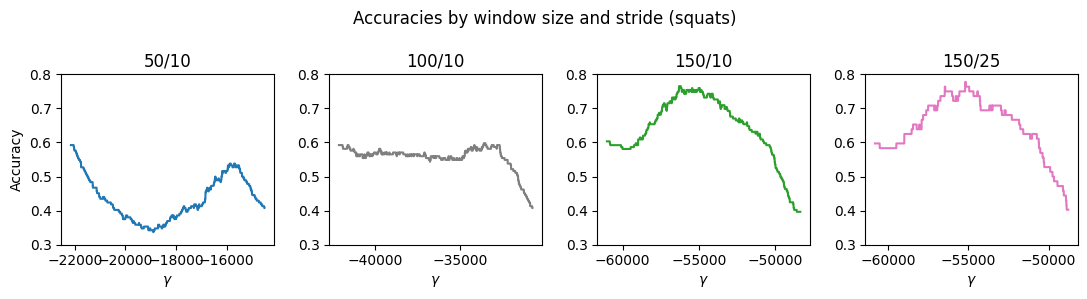

In [110]:
# Accuracies vs gamma plot for each experiment
fig = plt.figure(figsize=(11, 3))

# 50/10
plt.subplot(1, 4, 1)
plt.ylim(0.3, 0.8)
plt.plot(squat_50_10_gammas, squat_50_10_accs_arr, color="tab:blue")
plt.title("50/10")
plt.ylabel("Accuracy")
plt.xlabel("$\gamma$")

# 100/10
plt.subplot(1, 4, 2)
plt.ylim(0.3, 0.8)
plt.plot(squat_gammas, squat_accs_arr, color="tab:grey")
plt.title("100/10")
plt.xlabel("$\gamma$")

# 150/10
plt.subplot(1, 4, 3)
plt.ylim(0.3, 0.8)
plt.plot(squat_150_10_gammas, squat_150_10_accs_arr, color="tab:green")
plt.title("150/10")
plt.xlabel("$\gamma$")

# 150/25
plt.subplot(1, 4, 4)
plt.ylim(0.3, 0.8)
plt.plot(squat_150_25_gammas, squat_150_25_accs_arr, color="tab:pink")
plt.title("150/25")
plt.xlabel("$\gamma$")

plt.suptitle("Accuracies by window size and stride (squats)")
plt.tight_layout()

And I got what I about what I expected, with some interesting nuance to it.

- With a **window size of 50** the maximum accuracy was just less than **60%** - only just better than a coinflip. This decision turned out to simply be guessing $\mathcal{H}_1$ every time.
- However, with a **window size of 100**, the maximum accuracy was *only* just higher than the max accuracy with a 50-measurement window. Only just better than simply guessing $\mathcal{H}_1$! And comparing it to the ground truth, it does in fact look quite poor.
- But when I went to a **window size of 150**, the maximum accuracy shot up to about **78%**! Far better - this showed me that more data being taken into consideration at each instant of decision made those decisions more accurate.
- Stride also, as expected, didn't make any difference to accuracy as decisions were independent from each other, but it did make computation faster.

## Hypothesis plots of max accuracy hypothesis sets by window size and stride

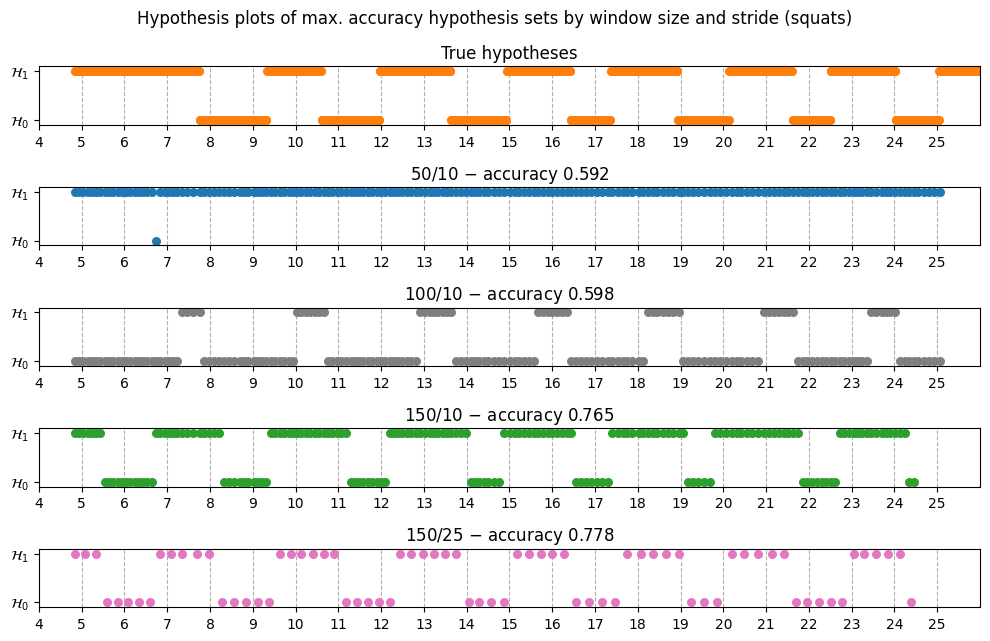

In [111]:
# Max accuracy hypothesis plots for each experiment
fig = plt.figure(figsize=(10, 6.5))
plt.suptitle(
    "Hypothesis plots of max. accuracy hypothesis sets by window size and stride (squats)"
)

# True hypotheses
plt.subplot(5, 1, 1)
plt.title("True hypotheses")
plot_hypotheses(
    squat_df_trim["seconds_elapsed"],
    squat_df_trim["hypothesis"],
    4,
    26,
    s=dot_size,
    color="tab:orange",
)

# 50/10
plt.subplot(5, 1, 2)
plt.title(f"50/10 $-$ accuracy {np.max(squat_50_10_accs_arr):.3f}")
plot_hypotheses(
    squat_df_trim_s10["seconds_elapsed"],
    squat_50_10_hyp_sets[np.argmax(squat_50_10_accs_arr)],
    4,
    26,
    s=dot_size,
    color="tab:blue",
)

# 100/10
plt.subplot(5, 1, 3)
plt.title(f"100/10 $-$ accuracy {np.max(squat_accs_arr):.3f}")
plot_hypotheses(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_accs_arr)],
    4,
    26,
    s=dot_size,
    color="tab:grey",
)

# 150/10
plt.subplot(5, 1, 4)
plt.title(f"150/10 $-$ accuracy {np.max(squat_150_10_accs_arr):.3f}")
plot_hypotheses(
    squat_df_trim_s10["seconds_elapsed"][: len(squat_150_10_hyp_sets[0])],
    squat_150_10_hyp_sets[np.argmax(squat_150_10_accs_arr)],
    4,
    26,
    s=dot_size,
    color="tab:green",
)

# 150/25
plt.subplot(5, 1, 5)
plt.title(f"150/25 $-$ accuracy {np.max(squat_150_25_accs_arr):.3f}")
plot_hypotheses(
    squat_df_trim_s25["seconds_elapsed"][: len(squat_150_25_hyp_sets[0])],
    squat_150_25_hyp_sets[np.argmax(squat_150_25_accs_arr)],
    4,
    26,
    s=dot_size,
    color="tab:pink",
)

plt.tight_layout()

## ROC curve

For another comparison I used the classic ROC curve. This really highlights how the window size 50 decisions were absolutely terrible, falling under the $y=x$ line, the window size 100 ones were a little better, nearer that line but just above, and the window size 150 ones were far, far more valuable.

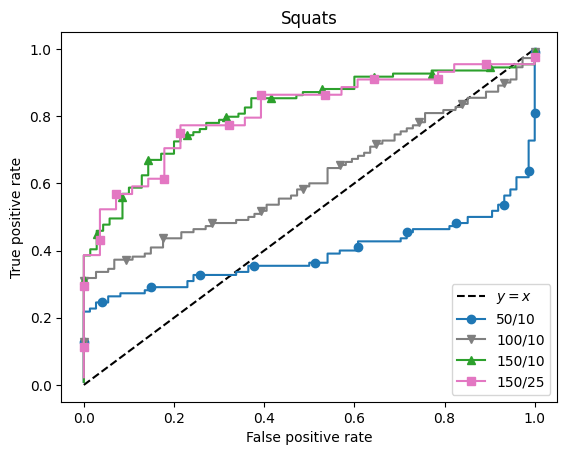

In [112]:
# ROC curve for comparison
# y = x baseline
plt.plot([0, 1], [0, 1], color="black", linestyle="--", label="$y = x$")

# 50/10
plt.plot(
    squat_50_10_false_pos_arr,
    squat_50_10_true_pos_arr,
    "o",
    ls="-",
    color="tab:blue",
    label="50/10",
    markevery=0.1,
)

# 100/10
plt.plot(
    squat_false_pos_arr,
    squat_true_pos_arr,
    "v",
    ls="-",
    color="tab:grey",
    label="100/10",
    markevery=0.1,
)

# 150/10
plt.plot(
    squat_150_10_false_pos_arr,
    squat_150_10_true_pos_arr,
    "^",
    ls="-",
    color="tab:green",
    label="150/10",
    markevery=0.1,
)

# 150/25
plt.plot(
    squat_150_25_false_pos_arr,
    squat_150_25_true_pos_arr,
    "s",
    ls="-",
    color="tab:pink",
    label="150/25",
    markevery=0.1,
)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Squats")
l = plt.legend()

# Conclusion

What I got from all this was this new approach to linear motion detection was very interesting indeed - a max accuracy of 78%, and computed far faster (and without the use of an utterly opaque machine learning model)!

As always, though, there were improvements to be made. More exercises to test the approach further, testing with data from other subjects (perhaps even a public dataset or two) and a three-hypothesis extension to the approach - the third hypothesis indicating zero motion - would have rendered curls a little more than "useless!" Discovering that curls weren't a particularly insightful exercise for this experiment was itself a learning experience, though.

**Did you find this interesting? Let me know - [shoot me an email](mailto:sambarker247@gmail.com).**